In [30]:
import torch
import librosa
import soundfile as sf
import argparse

import numpy as np

import os,glob
from tqdm import tqdm

from cRFConvTasNet import cRFConvTasNet
from ptUtils.hparams import HParam
from dataset import preprocess
import feature

from itertools import permutations

import matplotlib
matplotlib.use('Agg')
import matplotlib.pylab as plt
%matplotlib inline

config = "/home/kbh/work/DOA-Audio-Separation/config/dv5_v13.yaml"
device = "cuda:1"
chkpt = "/home/nas/user/kbh/DOA-Audio-Separation/chkpt/dv5_v13/bestmodel.pt"
modelsave_path = chkpt
os.makedirs("../demo_out/dv5_v13",exist_ok=True)

hp = HParam(config)
print("NOTE::Loading configuration : "+config)
n_target = hp.model.n_target
preemphasis=hp.data.preemphasis
dir_input = "../demo_in"
list_target = [x for x in glob.glob(os.path.join("../demo_in","*.wav"))]
torch.cuda.set_device(device)

N = n_target
L_t = hp.model.l_filter_t
L_f = hp.model.l_filter_f
C = hp.data.n_channel
F = int(hp.model.n_fft/2 + 1)
shift = int(hp.model.n_fft/4)



model = cRFConvTasNet(
    L_t=hp.model.l_filter_t,
    L_f=hp.model.l_filter_f,
    f_ch=hp.model.d_feature,
    n_fft=hp.model.n_fft,
    mask=hp.model.activation,
    n_target=n_target
).to(device)

print("LOAD : {}".format(chkpt))
model.load_state_dict(torch.load(chkpt, map_location=device))

phase_func = feature.cosIPD

# mic array 
pos_mic=[
    [-0.04,-0.04,0.00],
    [-0.04,+0.04,0.00],
    [+0.04,-0.04,0.00],
    [+0.04,+0.04,0.00]
]

pos_mic = np.array(pos_mic)
pos_mic = torch.from_numpy(pos_mic)

model.eval();


NOTE::Loading configuration : /home/kbh/work/DOA-Audio-Separation/config/dv5_v13.yaml
cRFConvTasNet::dim_input : 3084
LOAD : /home/nas/user/kbh/DOA-Audio-Separation/chkpt/dv5_v13/bestmodel.pt


  0%|                                                                            | 0/1 [00:00<?, ?it/s]/tmp/ipykernel_1980529/3418204536.py:104: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()
100%|████████████████████████████████████████████████████████████████████| 1/1 [00:23<00:00, 23.18s/it]


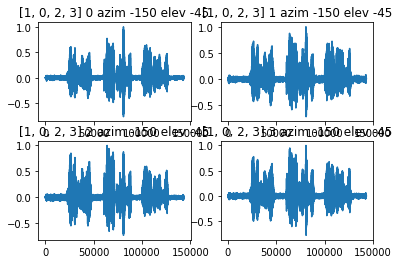

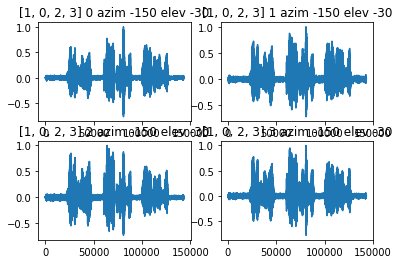

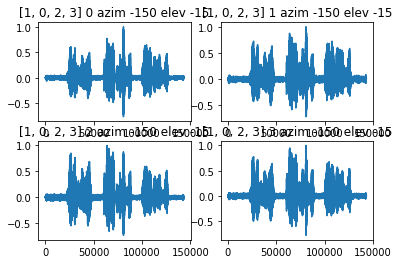

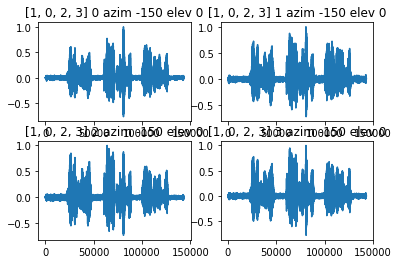

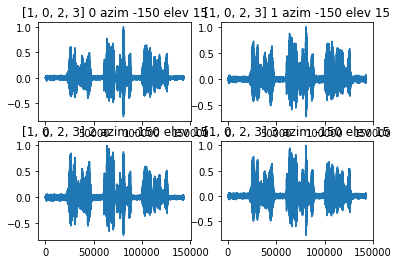

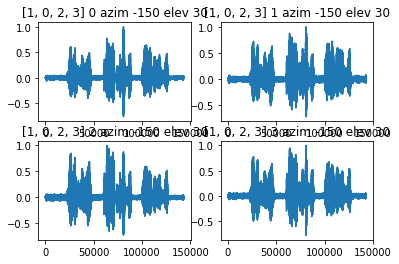

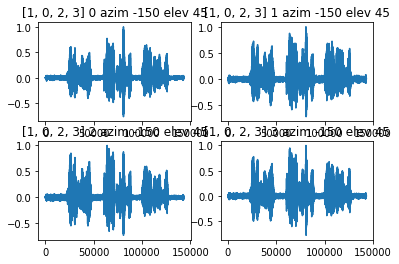

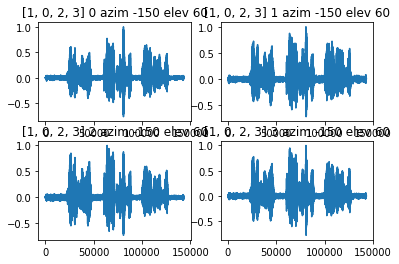

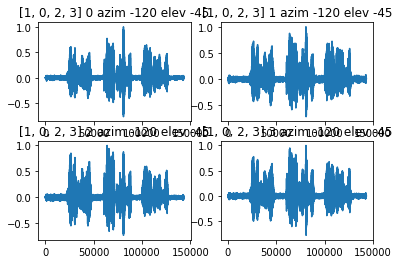

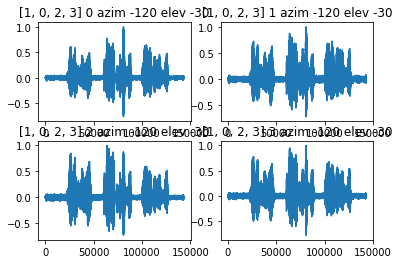

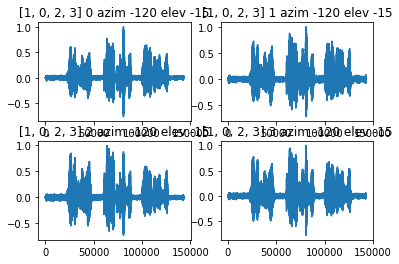

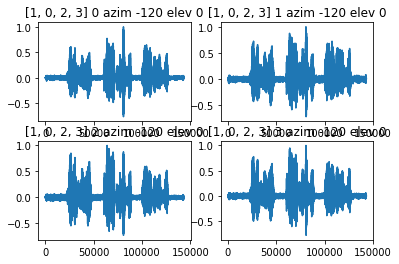

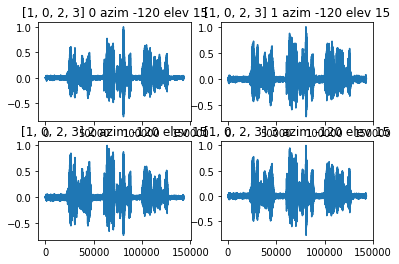

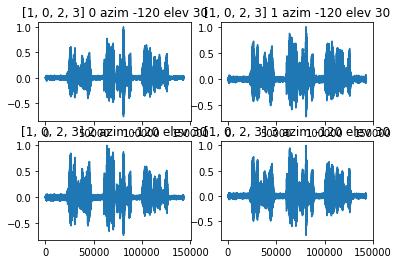

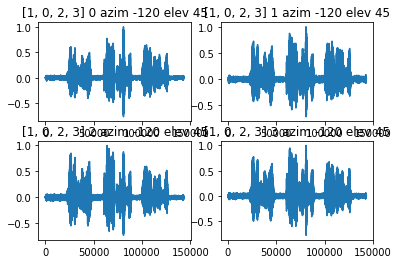

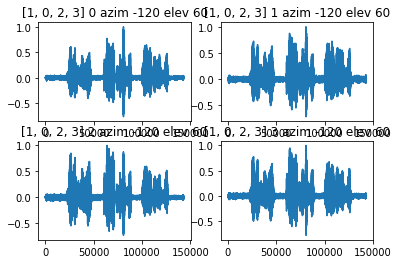

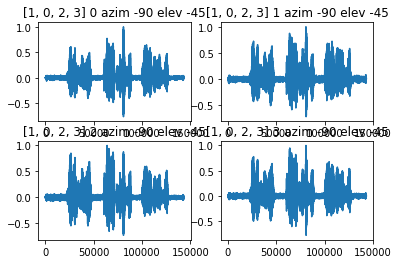

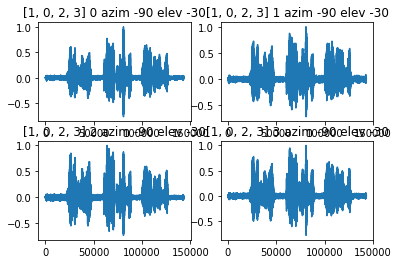

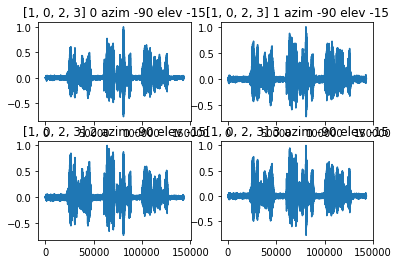

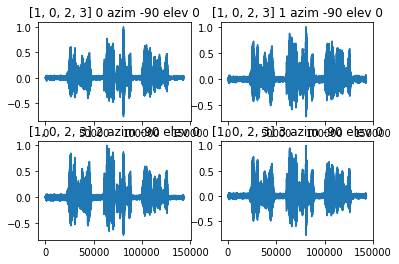

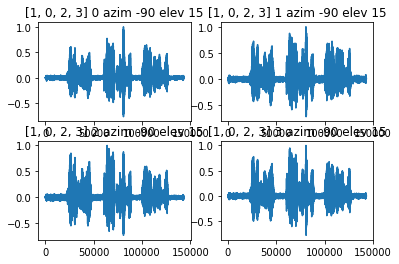

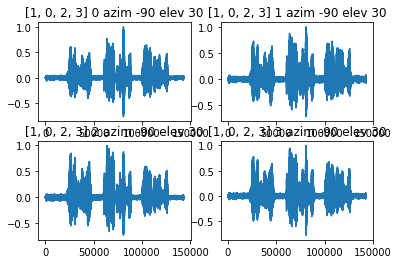

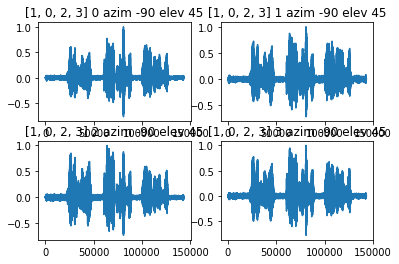

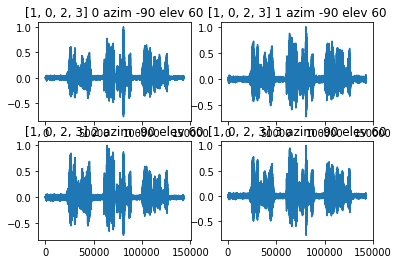

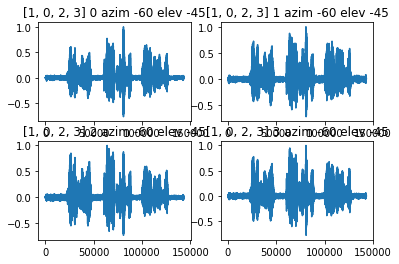

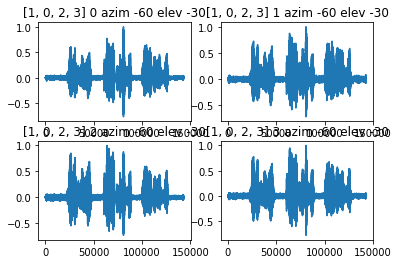

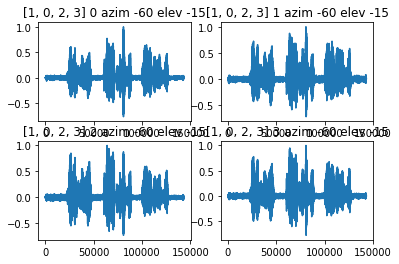

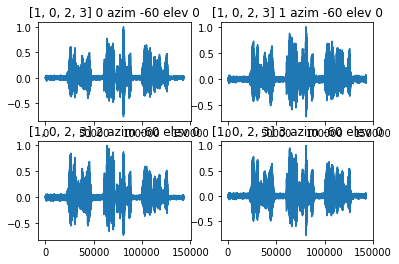

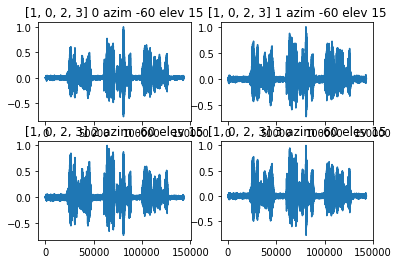

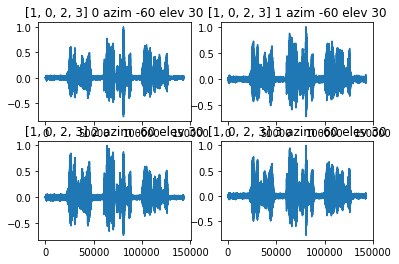

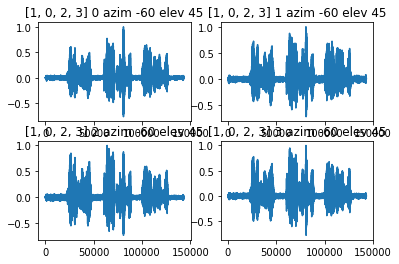

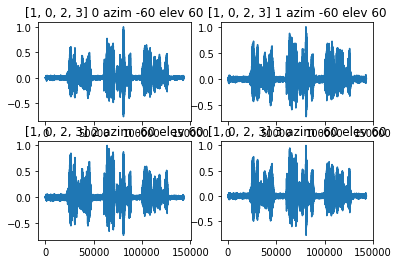

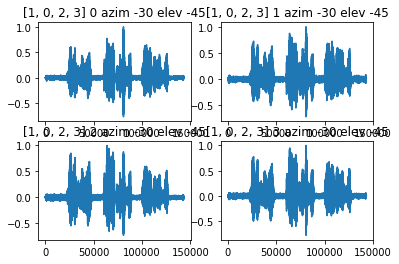

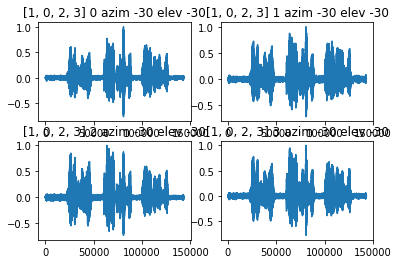

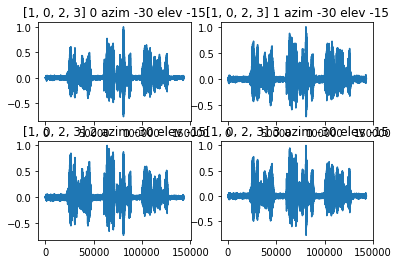

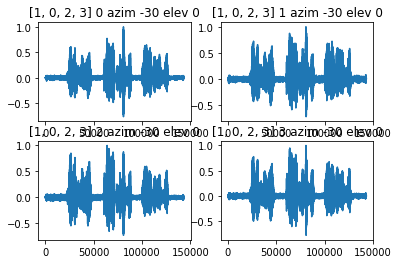

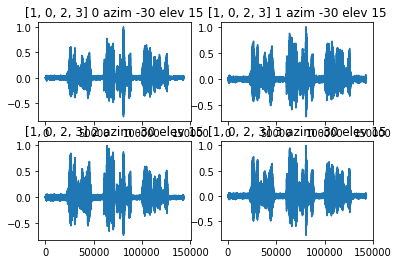

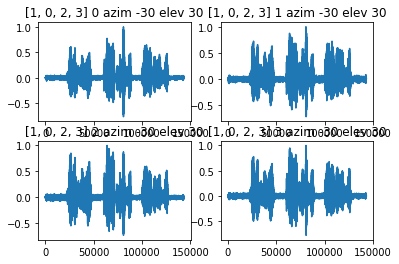

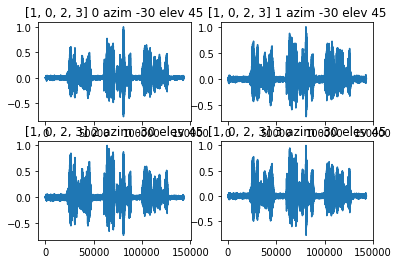

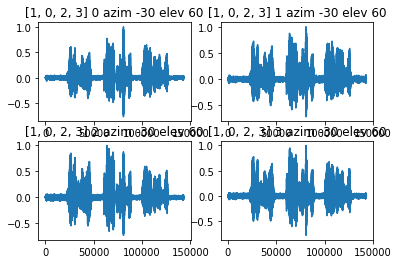

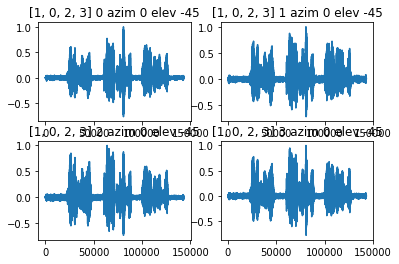

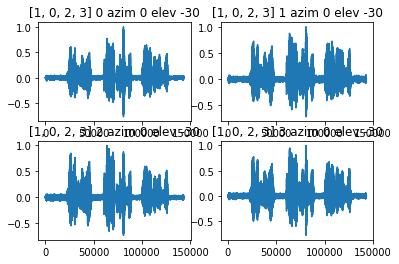

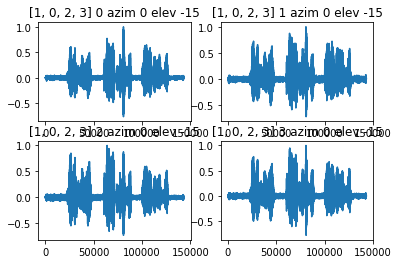

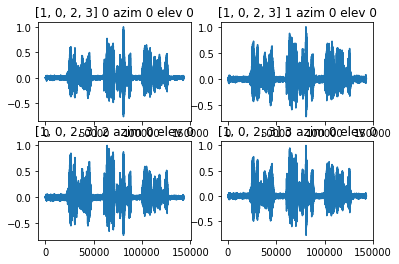

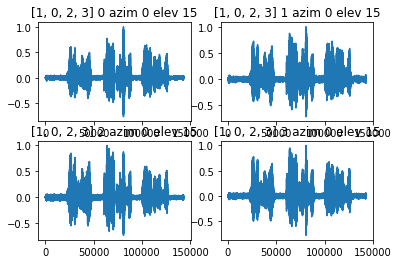

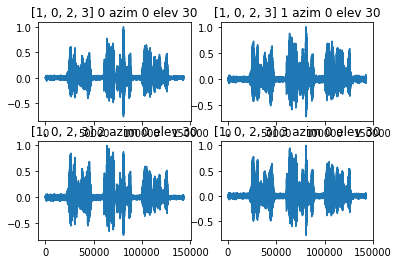

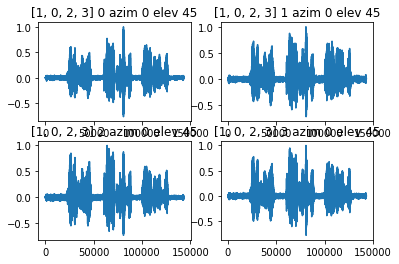

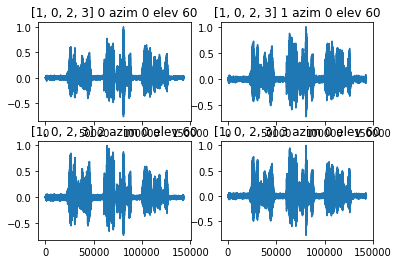

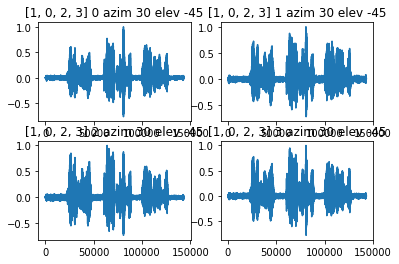

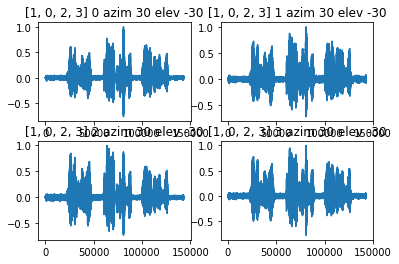

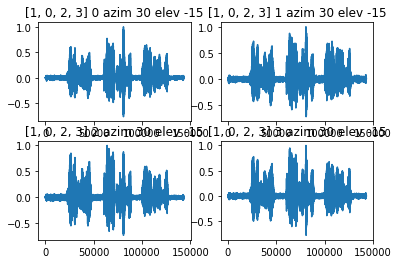

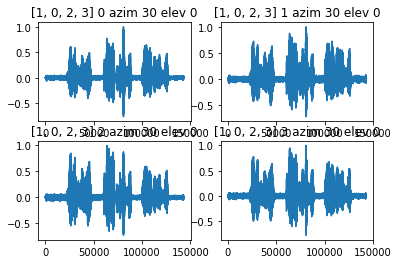

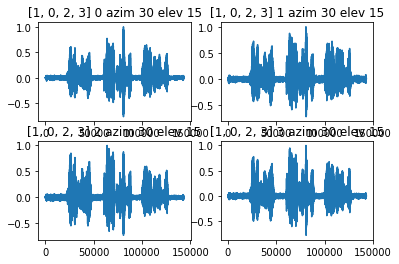

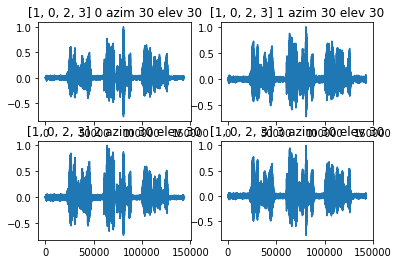

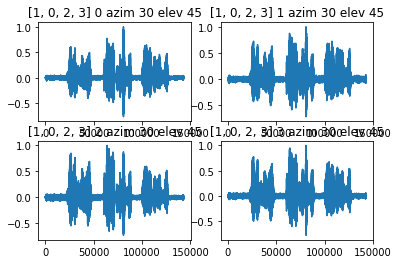

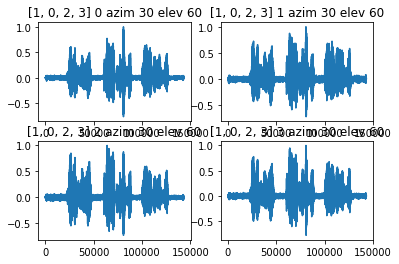

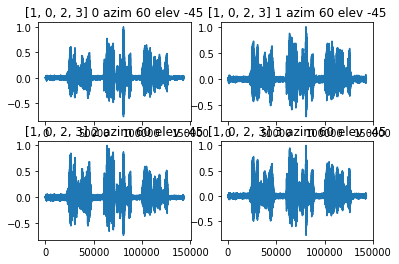

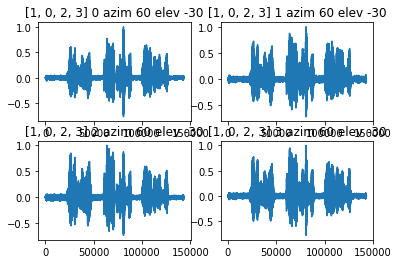

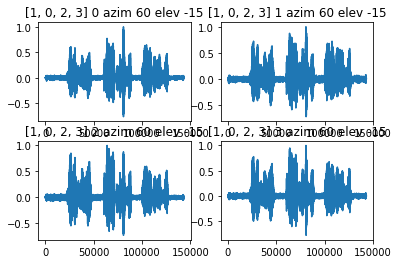

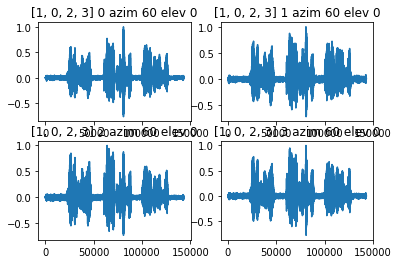

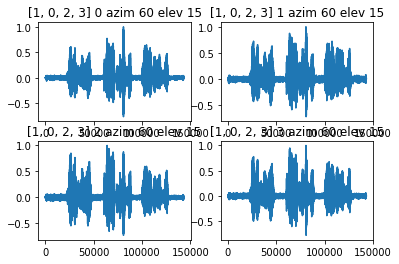

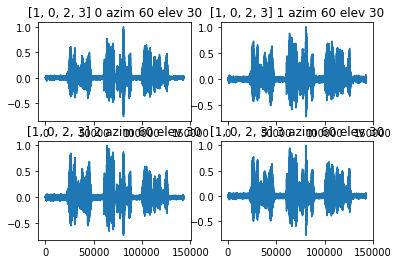

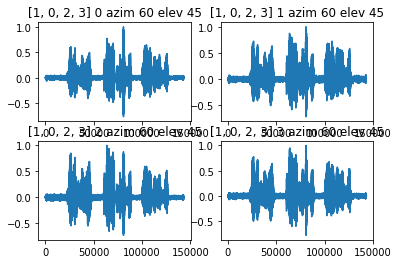

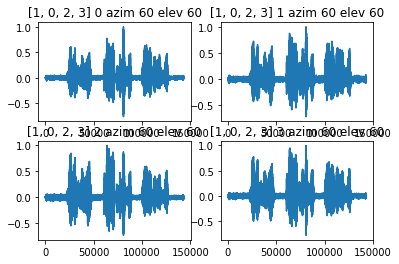

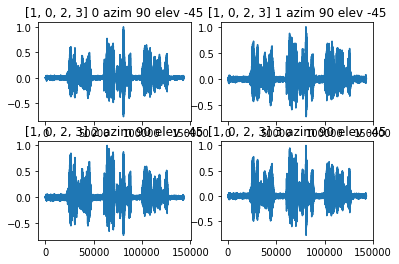

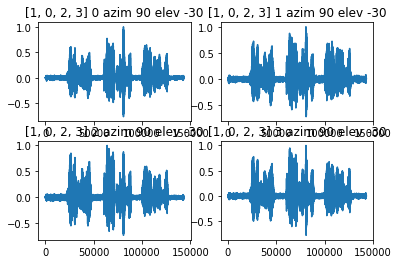

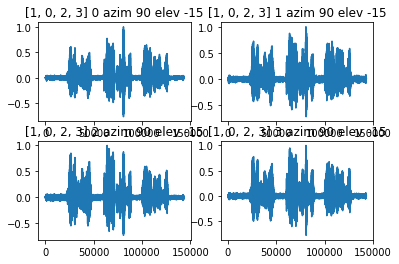

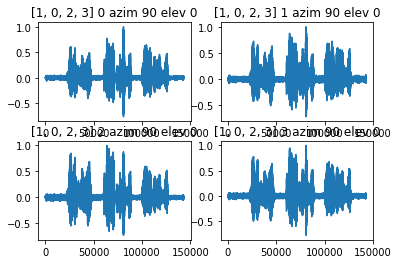

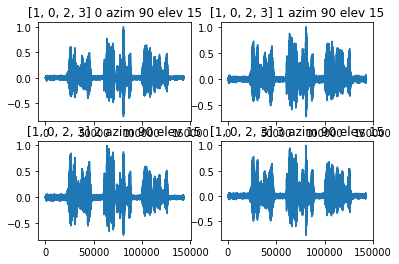

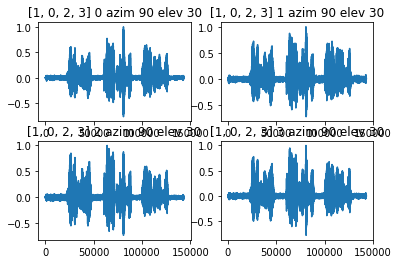

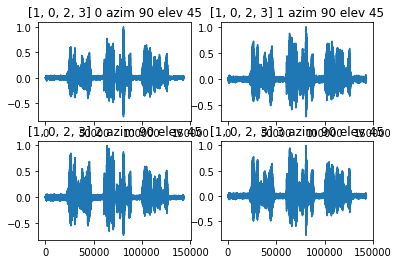

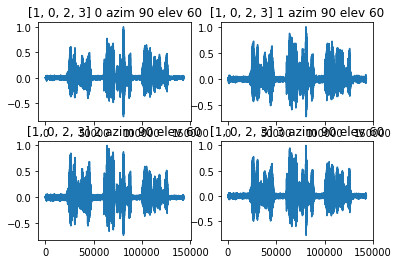

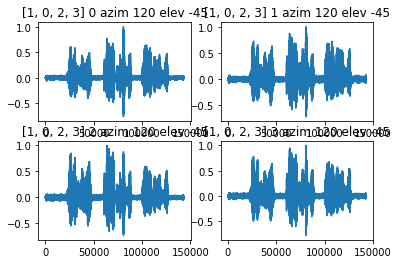

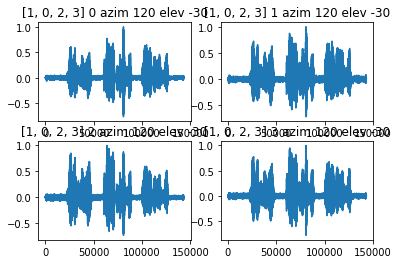

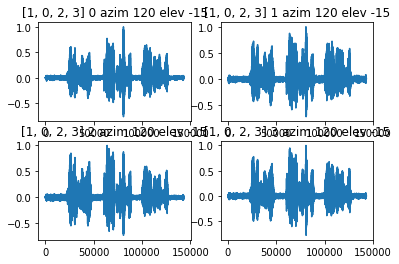

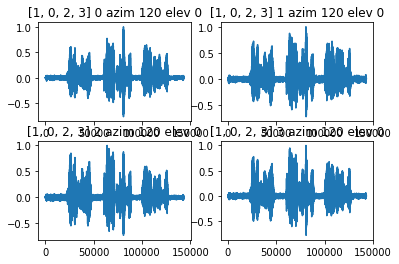

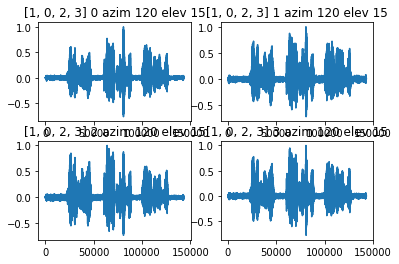

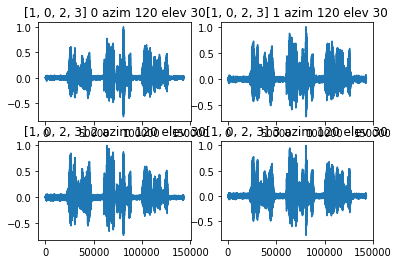

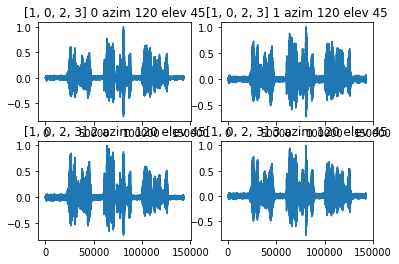

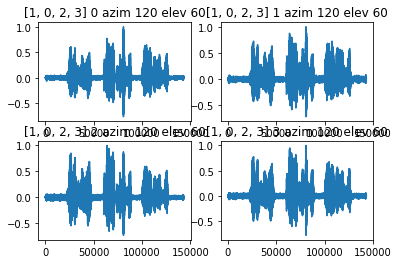

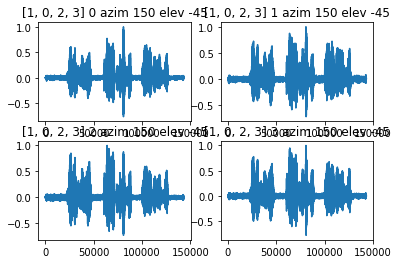

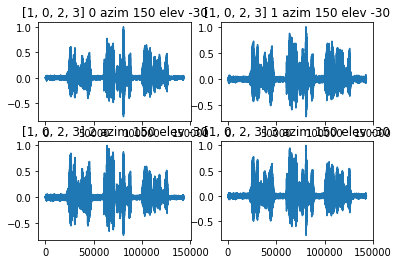

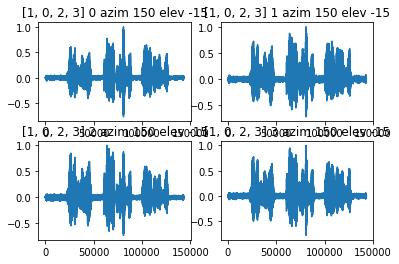

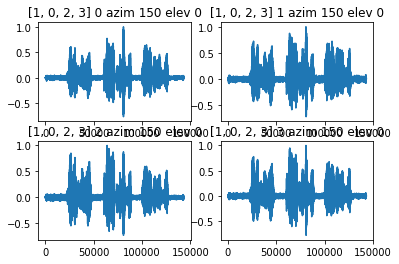

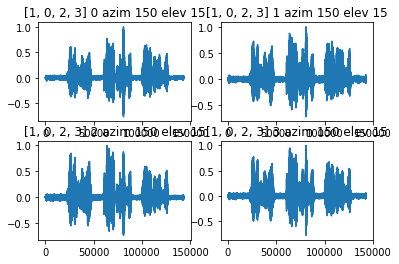

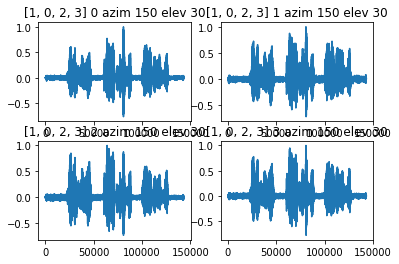

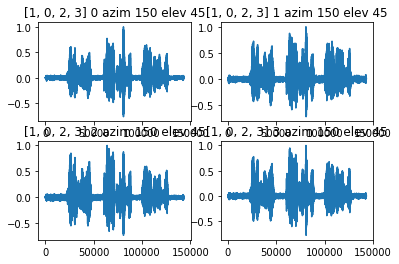

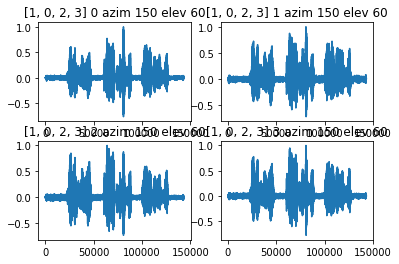

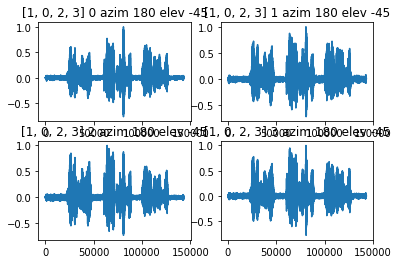

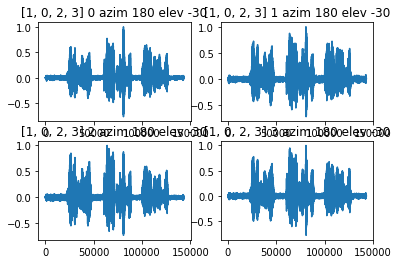

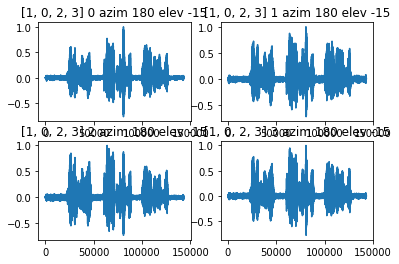

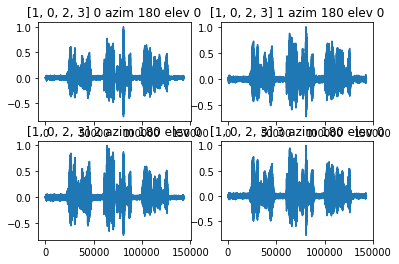

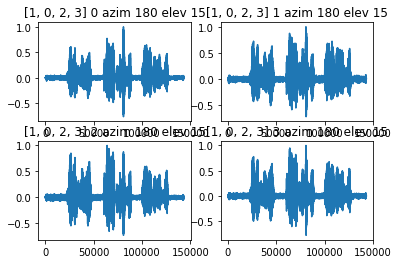

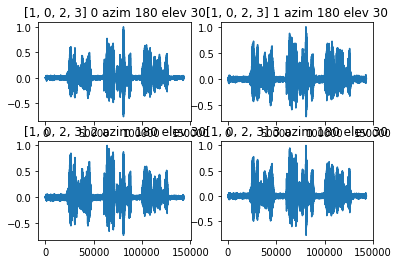

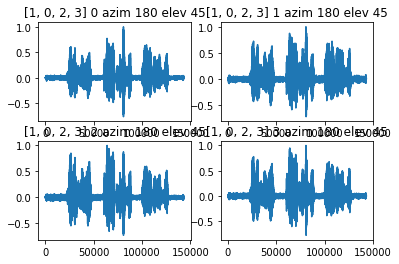

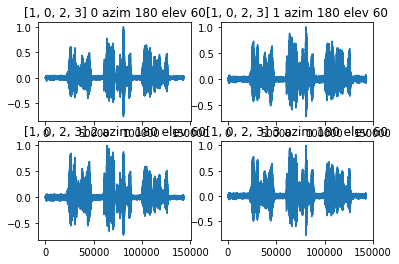

In [31]:

with torch.no_grad():
    for path_target in tqdm(list_target) : 
        
        name_target = path_target.split('/')[-1]
        id_target = name_target.split('.')[0]

        raw,_ = librosa.load(path_target,sr=16000,mono=False)
       # print("{} {}".format(path_target,raw.shape))
        short = raw.shape[1]%128

        if short != 0 : 
            raw = raw[:,:-short]

       # print("raw : {} {}".format(raw.shape,short))

        raw = raw/np.max(np.abs(raw))

       
        t_c = []
        t_c.append(raw[0,:])
        t_c.append(raw[1,:])
        t_c.append(raw[2,:])
        t_c.append(raw[3,:])
        
        #for i_perm in list(permutations([0,1,2,3])):
        for i_perm in [[1,0,2,3]]:
            for i_azim in [-150,-120,-90,-60,-30,0,30,60,90,120,150,180] : 
                for i_elev in [-45, -30, -15, 0,15,30,45,60] :

                    """
                    pos_mic
                    +y
                        2    4

                        1    3    +x

                    """

                    raw[0,:] = t_c[i_perm[0]]
                    raw[1,:] = t_c[i_perm[1]]
                    raw[2,:] = t_c[i_perm[2]]
                    raw[3,:] = t_c[i_perm[3]]



                    #raw[3,:] = t_c[2]
                    #raw[2,:] = t_c[3]


                    # azimuth, elevation : [n_src,n_frame]
                    path_doa = os.path.join(dir_input,id_target+".npy")

                    label = np.load(path_doa)

                    azimuth   = torch.from_numpy(label[:,0,:])
                    elevation = torch.from_numpy(label[:,1,:])
                    
                    azimuth[:,:] = i_azim 
                    azimuth[1,:] += 90
                    azimuth[2,:] += 180
                    azimuth[3,:] += 270
                    elevation[:,:]=i_elev

                    feature,stft,dup = preprocess(raw,azimuth,elevation,pos_mic,phase_func)
                    T = stft.shape[2]
                    feature = torch.unsqueeze(feature,dim=0)
                    stft = torch.unsqueeze(stft,dim=0)

                    feature = feature.to(device)
                    filter = model(feature)

                    ## filtering
                    # [B,C,F,T]
                    input = stft.to(device)

                    # dim of pad start from last dim
                    input_alt = torch.nn.functional.pad(input,pad=(L_t,L_t,L_f,L_f) ,mode="constant", value=0)
                    output = torch.zeros((input.shape[0],N,C,F,T),dtype=torch.cfloat).to(device)

                    for t in range(2*L_t+1) : 
                        for f in range(2*L_f+1):
                            for n in range(N) : 
                                output[:,n,:,:,:] += torch.mul(
                                    input_alt[: , : , f:F+f , t:T+t ],
                                    filter[:,n,:,f,t,:,:]
                                    )

                    #print(torch.abs(filter).max())
                    #print(torch.abs(filter).min())
                    # iSTFT
                    output_raw = torch.zeros((1,N,C,raw.shape[1])).to(device)

                    # torch does not supprot batch STFT/iSTFT
                    for j in range(output_raw.shape[1]) :
                        for k in range(output_raw.shape[2]) : 
                            output_raw[:,j,k,:] = torch.istft(output[:,j,k,:,:],n_fft = hp.model.n_fft)

                    ## Normalization
                    denom_max = torch.max(torch.abs(output_raw),dim=3)[0]
                    denom_max = torch.unsqueeze(denom_max,dim=-1)
                    output_raw = output_raw/denom_max

                    output_raw = output_raw.cpu().detach().numpy()
                    plt.figure()
                    for j in range(N):
                        plt.subplot(2, 2, j+1)
                        plt.title("{} {} azim {} elev {}".format(i_perm,j,i_azim,i_elev))
                        plt.plot(output_raw[0,j,0,:])

                    #for j in range(N) : 
                    #    #sf.write(args.dir_output+'/'+id_target+'_'+str(j)+'.wav',output_raw[0,j,:,:].T,16000)
                    #    sf.write(args.dir_output+'/'+id_target+'_'+str(j)+'.wav',output_raw[0,j,0,:].T,16000)